In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/Alcohol_Sales.csv')
df['Month']= pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
#df.index.freq='MS'

In [41]:
df.head()

,Sales
Month,
1992-01-01,3459
1992-01-02,3458
1992-01-03,4002
1992-01-04,4564
1992-01-05,4221


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


<AxesSubplot:xlabel='Month'>

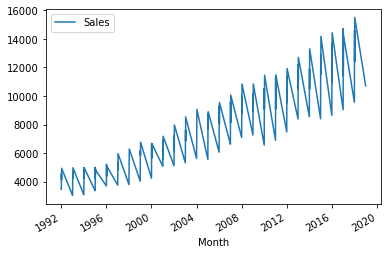

In [43]:
df.plot()

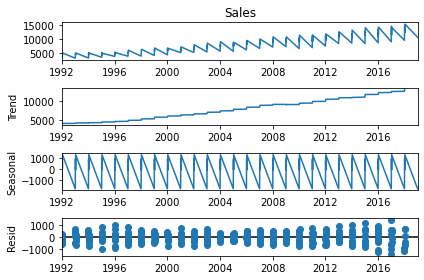

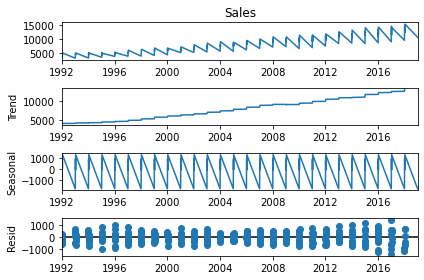

In [45]:
results = seasonal_decompose(df['Sales'], freq=12)
results.plot()

In [46]:
len(df)

325

In [47]:
train = df.iloc[:300]
test = df.iloc[300:]

scaler = MinMaxScaler()

In [48]:
df.head(), df.tail()

(            Sales
 Month            
 1992-01-01   3459
 1992-01-02   3458
 1992-01-03   4002
 1992-01-04   4564
 1992-01-05   4221,
             Sales
 Month            
 2018-01-09  12396
 2018-01-10  13914
 2018-01-11  14174
 2018-01-12  15504
 2019-01-01  10718)

In [49]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.03757682],
       [0.03748903],
       [0.08525022],
       [0.13459175],
       [0.10447761],
       [0.13151888],
       [0.12598771],
       [0.09710272],
       [0.09613696],
       [0.10781387]])

# Recursive Strategy

In [50]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(scaled_train),len(generator))

300 297


In [51]:
X,y = generator[0]
print(X.flatten())
print(y)

[0.03757682 0.03748903 0.08525022]
[[0.13459175]]


In [52]:
X.shape

(1, 3, 1)

In [53]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.03757682],
         [0.03748903],
         [0.08525022],
         [0.13459175],
         [0.10447761],
         [0.13151888],
         [0.12598771],
         [0.09710272],
         [0.09613696],
         [0.10781387],
         [0.10614574],
         [0.16725198]]]),
 array([[0.]]))

In [54]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(generator, epochs=50, verbose=0)

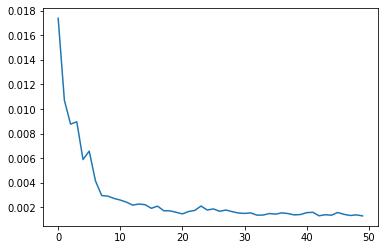

In [56]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [57]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.5405587]], dtype=float32)

In [58]:
scaled_test[0], scaled_test[1]

(array([0.52783143]), array([0.65153644]))

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.5405587], dtype=float32),
 array([0.729704], dtype=float32),
 array([0.81863785], dtype=float32),
 array([0.79146105], dtype=float32),
 array([0.86288685], dtype=float32),
 array([1.0078087], dtype=float32),
 array([0.7423436], dtype=float32),
 array([0.92291415], dtype=float32),
 array([0.82884514], dtype=float32),
 array([0.84980243], dtype=float32),
 array([0.92509156], dtype=float32),
 array([1.1030207], dtype=float32),
 array([0.5914016], dtype=float32),
 array([0.8184597], dtype=float32),
 array([0.83091116], dtype=float32),
 array([0.8611482], dtype=float32),
 array([0.90907794], dtype=float32),
 array([1.1314481], dtype=float32),
 array([0.7834286], dtype=float32),
 array([1.030739], dtype=float32),
 array([0.83245385], dtype=float32),
 array([0.94226366], dtype=float32),
 array([0.9624052], dtype=float32),
 array([1.3327471], dtype=float32),
 array([0.63491446], dtype=float32)]

In [60]:
test.head()

,Sales
Month,
2017-01-01,9043
2017-01-02,10452
2017-01-03,12481
2017-01-04,11491
2017-01-05,13545


In [61]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

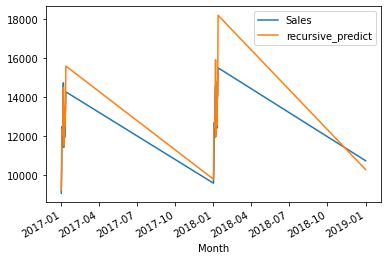

In [62]:
test.plot()

In [64]:
rmse = sqrt(mean_squared_error(test['Sales'], test['recursive_predict']))
print(rmse)

877.0285589190515


In [65]:
test

,Sales,recursive_predict
Month,,
2017-01-01,9043,9187.963545
2017-01-02,10452,11342.328815
2017-01-03,12481,12355.285088
2017-01-04,11491,12045.741365
2017-01-05,13545,12859.281177
2017-01-06,14730,14509.940926
2017-01-07,11416,11486.293656
2017-01-08,13402,13542.992139
2017-01-09,11907,12471.546182


# Direct Startegy

In [66]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [67]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [68]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.6141867], dtype=float32),
 array([0.80726], dtype=float32),
 array([0.84918684], dtype=float32),
 array([0.84661394], dtype=float32),
 array([0.9022486], dtype=float32),
 array([0.9015599], dtype=float32),
 array([0.8860966], dtype=float32),
 array([0.87735194], dtype=float32),
 array([0.9015399], dtype=float32),
 array([0.85137177], dtype=float32),
 array([0.9817041], dtype=float32),
 array([0.97550416], dtype=float32),
 array([0.6550342], dtype=float32),
 array([0.7661675], dtype=float32),
 array([0.88350236], dtype=float32),
 array([0.8565924], dtype=float32),
 array([0.8874834], dtype=float32),
 array([0.9119443], dtype=float32),
 array([0.8856331], dtype=float32),
 array([0.8740044], dtype=float32),
 array([0.90547013], dtype=float32),
 array([0.9084529], dtype=float32),
 array([0.89551204], dtype=float32),
 array([0.9394262], dtype=float32),
 array([0.74709475], dtype=float32)]

In [69]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

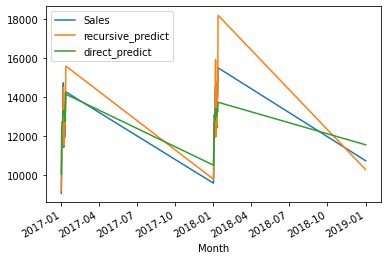

In [70]:
test.plot()

In [71]:
rmse = sqrt(mean_squared_error(test['Sales'], test['direct_predict']))
print(rmse)

1044.304350025836


In [72]:
test

,Sales,recursive_predict,direct_predict
Month,,,
2017-01-01,9043,9187.963545,10026.586560
2017-01-02,10452,11342.328815,12225.691136
2017-01-03,12481,12355.285088,12703.238081
2017-01-04,11491,12045.741365,12673.932817
2017-01-05,13545,12859.281177,13307.611793
2017-01-06,14730,14509.940926,13299.767139
2017-01-07,11416,11486.293656,13123.640237
2017-01-08,13402,13542.992139,13024.038593
2017-01-09,11907,12471.546182,13299.539709


# Direct Recursive Startegy

In [73]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [74]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [75]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.5768553], dtype=float32),
 array([0.78377444], dtype=float32),
 array([0.81456065], dtype=float32),
 array([0.87659657], dtype=float32),
 array([0.8839094], dtype=float32),
 array([0.87604773], dtype=float32),
 array([0.8542681], dtype=float32),
 array([0.7837624], dtype=float32),
 array([0.8567888], dtype=float32),
 array([0.8253929], dtype=float32),
 array([0.7879057], dtype=float32),
 array([0.9035675], dtype=float32),
 array([0.72990483], dtype=float32),
 array([0.88726705], dtype=float32),
 array([0.82422423], dtype=float32),
 array([0.8735504], dtype=float32),
 array([0.803921], dtype=float32),
 array([0.86107755], dtype=float32),
 array([0.8202989], dtype=float32),
 array([0.9221462], dtype=float32),
 array([0.9121236], dtype=float32),
 array([0.9094977], dtype=float32),
 array([0.8362565], dtype=float32),
 array([0.807623], dtype=float32),
 array([0.99711424], dtype=float32)]

In [76]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

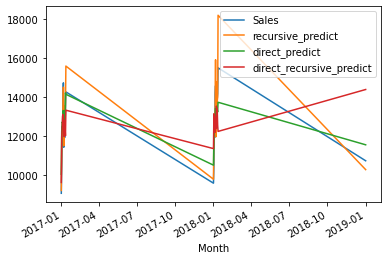

In [77]:
test.plot()

In [78]:
rmse = sqrt(mean_squared_error(test['Sales'], test['direct_recursive_predict']))
print(rmse)

1583.1390903575893


In [79]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict
Month,,,,
2017-01-01,9043,9187.963545,10026.586560,9601.381888
2017-01-02,10452,11342.328815,12225.691136,11958.190821
2017-01-03,12481,12355.285088,12703.238081,12308.845824
2017-01-04,11491,12045.741365,12673.932817,13015.434932
2017-01-05,13545,12859.281177,13307.611793,13098.728115
2017-01-06,14730,14509.940926,13299.767139,13009.183650
2017-01-07,11416,11486.293656,13123.640237,12761.113363
2017-01-08,13402,13542.992139,13024.038593,11958.053683
2017-01-09,11907,12471.546182,13299.539709,12789.824592


# MIMO

In [102]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [103]:
n_input = 12
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [104]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [105]:
model.fit(X, y, epochs=50, verbose=0)

In [106]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_55 (Dense)             (None, 25)                5025      
Total params: 166,625
Trainable params: 166,625
Non-trainable params: 0
_________________________________________________________________


In [107]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [108]:
res.shape

(25, 1)

In [109]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [110]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Month,,,,,
2017-01-01,9043,9187.963545,10026.586560,9601.381888,11701.727539
2017-01-02,10452,11342.328815,12225.691136,11958.190821,11726.133789
2017-01-03,12481,12355.285088,12703.238081,12308.845824,11707.513672
2017-01-04,11491,12045.741365,12673.932817,13015.434932,11813.852539
2017-01-05,13545,12859.281177,13307.611793,13098.728115,11977.083984
2017-01-06,14730,14509.940926,13299.767139,13009.183650,11971.256836
2017-01-07,11416,11486.293656,13123.640237,12761.113363,11615.911133
2017-01-08,13402,13542.992139,13024.038593,11958.053683,12396.511719
2017-01-09,11907,12471.546182,13299.539709,12789.824592,12569.588867


<AxesSubplot:xlabel='Month'>

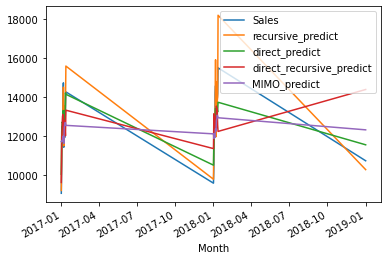

In [111]:
test.plot()

In [112]:
rmse = sqrt(mean_squared_error(test['Sales'], test['MIMO_predict']))
print(rmse)

1496.2961476262058


# Direct MIMO

In [113]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [114]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [115]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/5)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.78738385, 0.77587825, 0.76954305, 0.7711013 , 0.79512566]],
       dtype=float32),
 array([[0.7976623 , 0.7759151 , 0.81600606, 0.8596966 , 0.87092215]],
       dtype=float32),
 array([[0.87276363, 0.8776933 , 0.7880832 , 0.78425616, 0.80473256]],
       dtype=float32),
 array([[0.85684067, 0.865686  , 0.8881615 , 0.879678  , 0.8937469 ]],
       dtype=float32),
 array([[0.9115965 , 0.9369938 , 0.94494665, 0.9171471 , 0.8963099 ]],
       dtype=float32)]

In [116]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [117]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(25, 1)

In [118]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [119]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Month,,,,,,
2017-01-01,9043,9187.963545,10026.586560,9601.381888,11701.727539,11999.301758
2017-01-02,10452,11342.328815,12225.691136,11958.190821,11726.133789,11868.252930
2017-01-03,12481,12355.285088,12703.238081,12308.845824,11707.513672,11796.095703
2017-01-04,11491,12045.741365,12673.932817,13015.434932,11813.852539,11813.843750
2017-01-05,13545,12859.281177,13307.611793,13098.728115,11977.083984,12087.481445
2017-01-06,14730,14509.940926,13299.767139,13009.183650,11971.256836,12116.373047
2017-01-07,11416,11486.293656,13123.640237,12761.113363,11615.911133,11868.672852
2017-01-08,13402,13542.992139,13024.038593,11958.053683,12396.511719,12325.309570
2017-01-09,11907,12471.546182,13299.539709,12789.824592,12569.588867,12822.945312


<AxesSubplot:xlabel='Month'>

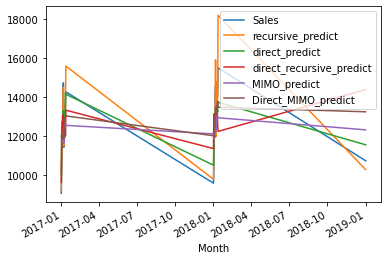

In [120]:
test.plot()

In [121]:
rmse = sqrt(mean_squared_error(test['Sales'], test['Direct_MIMO_predict']))
print(rmse)

1415.4145536003311


In [122]:
rec_err = abs(test['Sales'] - test['recursive_predict'])
dir_err = abs(test['Sales'] - test['direct_predict'])
dir_rec_err = abs(test['Sales'] - test['direct_recursive_predict'])
mimo_err = abs(test['Sales'] - test['MIMO_predict'])
dir_mimo_err = abs(test['Sales'] - test['Direct_MIMO_predict'])

In [123]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [124]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Month,,,,,
2017-01-01,144.963545,983.586560,558.381888,2658.727539,2956.301758
2017-01-02,890.328815,1773.691136,1506.190821,1274.133789,1416.252930
2017-01-03,125.714912,222.238081,172.154176,773.486328,684.904297
2017-01-04,554.741365,1182.932817,1524.434932,322.852539,322.843750
2017-01-05,685.718823,237.388207,446.271885,1567.916016,1457.518555
2017-01-06,220.059074,1430.232861,1720.816350,2758.743164,2613.626953
2017-01-07,70.293656,1707.640237,1345.113363,199.911133,452.672852
2017-01-08,140.992139,377.961407,1443.946317,1005.488281,1076.690430
2017-01-09,564.546182,1392.539709,882.824592,662.588867,915.945312


<AxesSubplot:xlabel='Month'>

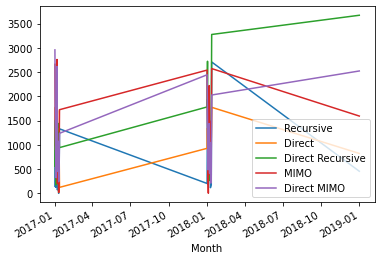

In [125]:
errors.plot()